<span style="font-size:30px;">Packages</span>

In [1]:
from dask.distributed import Client
from glob import glob
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import cartopy.mpl.ticker as cticker
import numpy as np
from requests.auth import HTTPBasicAuth
import requests
import regionmask

<span style="font-size:30px;">Read data</span>

In [2]:
flist_control=sorted(glob('/g/data/bs94/AUS2200/coralsea-sstobs/v1-0/10min/pralsprof/pralsprof_AUS2200_flood22-coralsea-control_subhr_2022*.nc'))
flist_exp=sorted(glob('/g/data/bs94/AUS2200/coralsea-sstreduced/v1-0/10min/pralsprof/pralsprof_AUS2200_flood22-reducedsst_subhr_2022*.nc'))
flist_imerg=sorted(glob('/g/data/ia39/aus-ref-clim-data-nci/gpm/data/V07/2022/3B-HHR.MS.MRG.3IMERG.2022*.nc'))

In [3]:
flist_control.remove('/g/data/bs94/AUS2200/coralsea-sstobs/v1-0/10min/pralsprof/pralsprof_AUS2200_flood22-coralsea-control_subhr_20220220000500-20220220235500.nc')
flist_exp.remove('/g/data/bs94/AUS2200/coralsea-sstreduced/v1-0/10min/pralsprof/pralsprof_AUS2200_flood22-reducedsst_subhr_20220222000500-20220222235500.nc')
flist_imerg.remove('/g/data/ia39/aus-ref-clim-data-nci/gpm/data/V07/2022/3B-HHR.MS.MRG.3IMERG.20220220.V07A.nc')

In [4]:
client=Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32913 instead
  warnings.warn(


<span style="font-size:30px;">Analysis</span>

In [5]:
ds_control = xr.open_mfdataset(flist_control,parallel=True,preprocess=lambda x: x['pralsprof'])
ds_exp = xr.open_mfdataset(flist_exp,parallel=True,preprocess=lambda x: x['pralsprof'])
ds_imerg = xr.open_mfdataset(flist_imerg,parallel=True,preprocess=lambda x: x['precipitation'])

In [6]:
da_fin_control=ds_control.resample(time='1D',offset='23h').sum()
da_fin_exp=ds_exp.resample(time='1D',offset='23h').sum()
da_fin_imerg =ds_imerg.resample(time='1D',offset='23h').sum()

In [7]:
precip_control=da_fin_control['pralsprof']
precip_exp=da_fin_exp['pralsprof']
precip_imerg =da_fin_imerg['precipitation']

In [8]:
precip_control=precip_control.sel(time=slice('2022-02-23T23:00:00.000000000','2022-03-01T23:00:00.000000000'))
precip_exp=precip_exp.sel(time=slice('2022-02-23T23:00:00.000000000','2022-03-01T23:00:00.000000000'))
precip_imerg=precip_imerg.sel(time=slice('2022-02-23T23:00:00.000000000','2022-03-01T23:00:00.000000000'))

In [9]:
precip_accum_control=precip_control.sum(dim='time')
precip_accum_exp=precip_exp.sum(dim='time')
precip_accum_imerg=precip_imerg.sum(dim='time')

In [10]:
#East Aust
EAust_precip_control=precip_accum_control.sel(lat=slice(-44,-10), lon=slice(143,159))
EAust_precip_exp=precip_accum_exp.sel(lat=slice(-44,-10), lon=slice(143,159))
EAust_precip_imerg=precip_accum_imerg.sel(lat=slice(-44,-10), lon=slice(143,159))

In [11]:
if EAust_precip_imerg.dims == ('lon', 'lat'):
    EAust_precip_imerg = EAust_precip_imerg.transpose('lat', 'lon')

In [12]:
precip_cont_minus_exp = EAust_precip_control - EAust_precip_exp

<span style="font-size:30px;">Plots</span>

In [13]:
#create colourbar
viridis = mpl.colormaps['viridis'].resampled(16)
newcolors = viridis(np.linspace(0, 1,16))
white=np.array([1,1,1,1])
newcolors[0:2,:] = white
newcmp = mcolors.ListedColormap(newcolors)

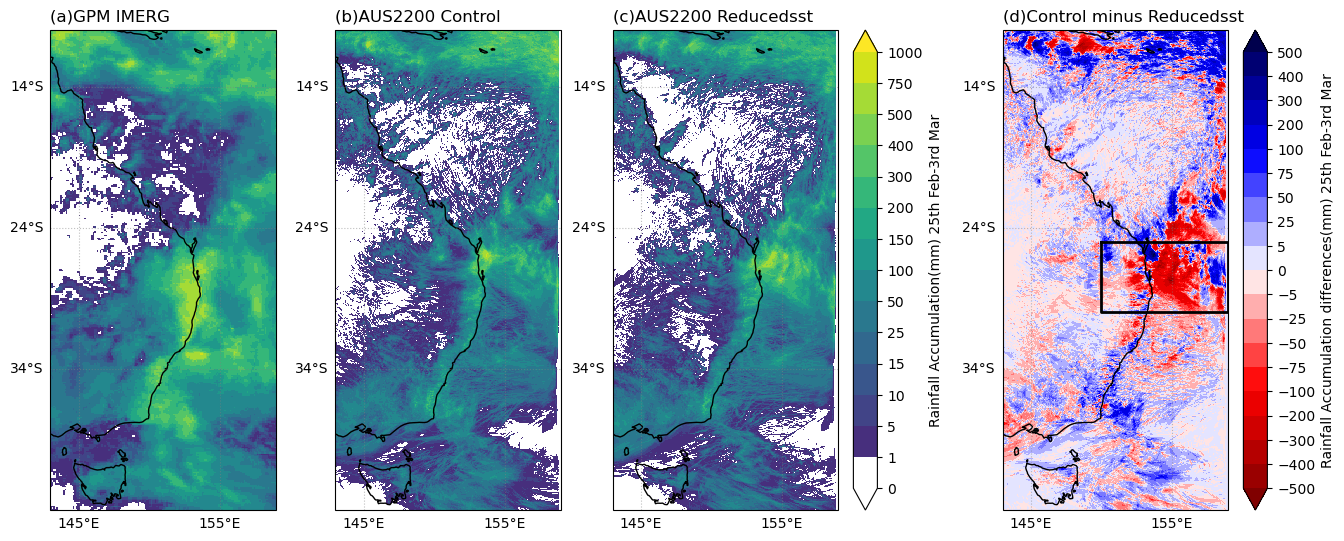

In [14]:
# Create a plot
plt.figure(figsize=(15, 6))

bounds = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400, 500, 750, 1000]  # define your boundaries
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=newcmp.N, extend='both')

ax = plt.axes([0.05, 0.9, 0.2, 0.8], projection = ccrs.PlateCarree())
ax.set_extent([143, 159, -44, -10], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle=':', xlocs=np.arange(135, 159, 10), ylocs=np.arange(-44, -10, 10))
gl.right_labels = False
gl.top_labels = False
ax.coastlines()
EAust_precip_imerg.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=newcmp, norm=norm, add_colorbar=False)
ax.set_title('(a)GPM IMERG', loc='left')

ax = plt.axes([0.24, 0.9, 0.2, 0.8], projection = ccrs.PlateCarree())
ax.set_extent([143, 159, -44, -10], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle=':', xlocs=np.arange(135, 159, 10), ylocs=np.arange(-44, -10, 10))
gl.right_labels = False
gl.top_labels = False
ax.coastlines()
EAust_precip_control.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=newcmp, norm=norm, add_colorbar=False)
ax.set_title('(b)AUS2200 Control', loc='left')

ax = plt.axes([0.44, 0.9, 0.2, 0.8], projection = ccrs.PlateCarree())
ax.set_extent([143, 159, -44, -10], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle=':', xlocs=np.arange(135, 159, 10), ylocs=np.arange(-44, -10, 10))
gl.right_labels = False
gl.top_labels = False
ax.coastlines()
EAust_precip_exp.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=newcmp, norm=norm,
    cbar_kwargs={
        'label': 'Rainfall Accumulation(mm) 25th Feb-3rd Mar',
        'extend': 'both',
        'spacing': 'uniform',
        'ticks': bounds,  # Set the ticks
        'boundaries': bounds,  # Ensure ticks align with boundaries
    }
 )
ax.set_title('(c)AUS2200 Reducedsst', loc='left')

bounds = [-500,-400,-300,-200,-100,-75,-50,-25,-5,0,5,25,50,75,100,200,300,400,500]  # define your boundaries
seismic = mpl.colormaps['seismic'].resampled(20)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=seismic.N, extend='both')

ax = plt.axes([0.7, 0.9, 0.2, 0.8], projection = ccrs.PlateCarree())
ax.set_extent([143, 159, -44, -10], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle=':', xlocs=np.arange(135, 159, 10), ylocs=np.arange(-44, -10, 10))
gl.right_labels = False
gl.top_labels = False
ax.coastlines()
precip_cont_minus_exp.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=seismic.reversed(), norm=norm,
    cbar_kwargs={
        'label': 'Rainfall Accumulation differences(mm) 25th Feb-3rd Mar', 
        'extend': 'both',
        'spacing': 'uniform',
        'ticks': bounds,  # Set the ticks
        'boundaries': bounds,  # Ensure ticks align with boundaries
    }
 )
ax.set_title('(d)Control minus Reducedsst', loc='left')

points = [[150, -25], [150, -30], [159, -30], [159, -25], [150, -25]]
lons = [point[0] for point in points]
lats = [point[1] for point in points]
ax.plot(lons, lats, color='black', linewidth=2, transform=ccrs.PlateCarree())

plt.show()

In [15]:
precip_control_daily = precip_control.resample(time='1D',offset='23h').sum()
precip_exp_daily = precip_exp.resample(time='1D',offset='23h').sum()
precip_cont_minus_exp_daily = precip_control_daily - precip_exp_daily
precip_daily = precip_cont_minus_exp_daily.sel(lat=slice(-44,-10), lon=slice(143,159))
lon = precip_daily.lon[:]
lat = precip_daily.lat[:]

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/pyth

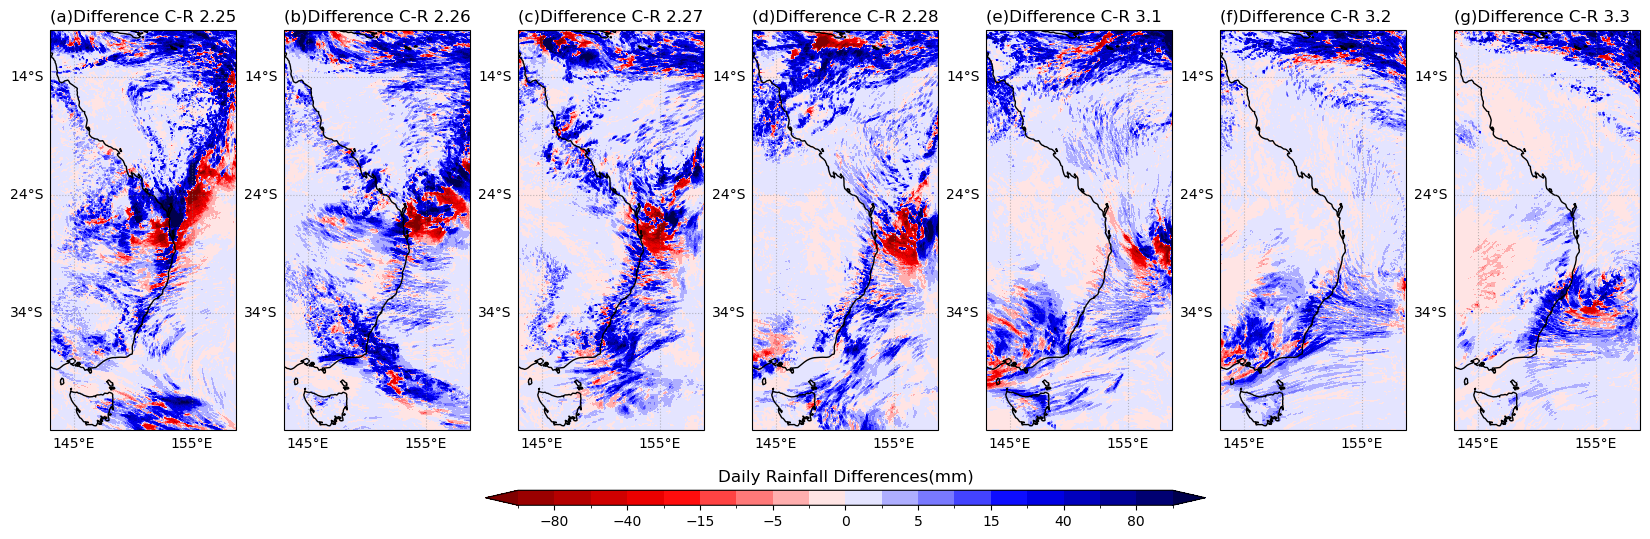

In [16]:
title = np.array(['(a)Difference C-R 2.25','(b)Difference C-R 2.26','(c)Difference C-R 2.27','(d)Difference C-R 2.28','(e)Difference C-R 3.1','(f)Difference C-R 3.2','(g)Difference C-R 3.3'])

bounds = [-100,-80,-60,-40,-20,-15,-10,-5,-1,0,1,5,10,15,20,40,60,80,100]  # define your boundaries
seismic = mpl.colormaps['seismic'].resampled(20)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=seismic.N, extend='both')

plt.figure(figsize=(18, 5))
for i in range(7):
    ax = plt.axes([0.04+i*0.13, 0.9, 0.12, 0.8], projection=ccrs.PlateCarree())
    ax.set_extent([143, 158.8, -44, -10], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle=':', xlocs=np.arange(135, 159, 10), ylocs=np.arange(-44, -10, 10))
    gl.right_labels = False
    gl.top_labels = False
    ax.coastlines()
    ax.set_title('{}'.format(title[i]), loc='left')
    cf1 = ax.contourf(lon, lat, precip_daily[i], bounds, norm=norm, transform=ccrs.PlateCarree(), cmap=seismic.reversed(), add_colorbar=False, extend='both')

position = plt.axes([0.29, 0.75, 0.4, 0.03])
cbar = plt.colorbar(cf1, cax=position, orientation='horizontal')
cbar.ax.set_title(r'Daily Rainfall Differences(mm)')

plt.show()